In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [19]:
def preprocess_data(df, has_target=True, le=None, scaler=None):
    # Drop junk first column if needed
    if df.columns[0] in [0, '0', 'NaN', None] or df.iloc[0,0] == 'NaN':
        df = df.drop(columns=df.columns[0])

    # Reset headers if first row contains names
    if 'age' in df.iloc[0].values:
        df.columns = df.iloc[0]
        df = df.drop(index=0).reset_index(drop=True)

    df = df.replace('?', np.nan).dropna().reset_index(drop=True)

    # Numeric + categorical cols
    numeric_cols = ['age', 'fnlwgt', 'education-num', 
                    'capital-gain', 'capital-loss', 'hours-per-week']
    categorical_cols = [col for col in df.columns if col not in numeric_cols + (['income'] if has_target else [])]

    # Convert numerics
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    if has_target:
        # Encode target
        le = LabelEncoder() if le is None else le
        df['income'] = le.fit_transform(df['income'])
        y = df[['income']]
    else:
        y = None

    # Features
    X = df.drop(columns=['income']) if has_target else df.copy()

    # One-hot encode categoricals
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Standardize numerics
    scaler = StandardScaler() if scaler is None else scaler
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols]) if has_target else scaler.transform(X[numeric_cols])

    return (X, y, le, scaler) if has_target else (X, scaler)


In [3]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
# ### Reading-in the Iris data

file_path = '/Users/kennedygracemaloney/Downloads/project_adult.csv'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
    print(f"\n********************* \nDataset Shape: {df.shape} \n********************* \nDataset Columns: \n{df.columns}\n********************* \nData Description: \n{df.describe()} \n********************* \nDoes Data Contain Null Values \n{df.isnull().all()}")
    print(f"\n********************* \n Counts of Response Variables: \n {df.iloc[:,4].value_counts()}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded '/Users/kennedygracemaloney/Downloads/project_adult.csv'. First 5 rows:
        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13   

In [7]:
# preprocess data with created function
X, y, le, scaler = preprocess_data(df)

First 5 Rows of Data before transformation: 
        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13              14      15  
0  capital-gain  capita

In [8]:
# split data into training and test datasets
# can specify same proportion of classes in both sets with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
# Initialize the model with default parameters.
# For multi-class problems, LogisticRegression uses a one-vs-rest strategy by default.
# The 'solver' is set to 'lbfgs' as it's a good default for multi-class problems.
model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
model.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=200, random_state=42)

In [10]:
# Make predictions on the scaled test set.
y_pred = model.predict(X_test)


--- Confusion Matrix ---
[[4207  331]
 [ 607  895]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4538
           1       0.73      0.60      0.66      1502

    accuracy                           0.84      6040
   macro avg       0.80      0.76      0.78      6040
weighted avg       0.84      0.84      0.84      6040



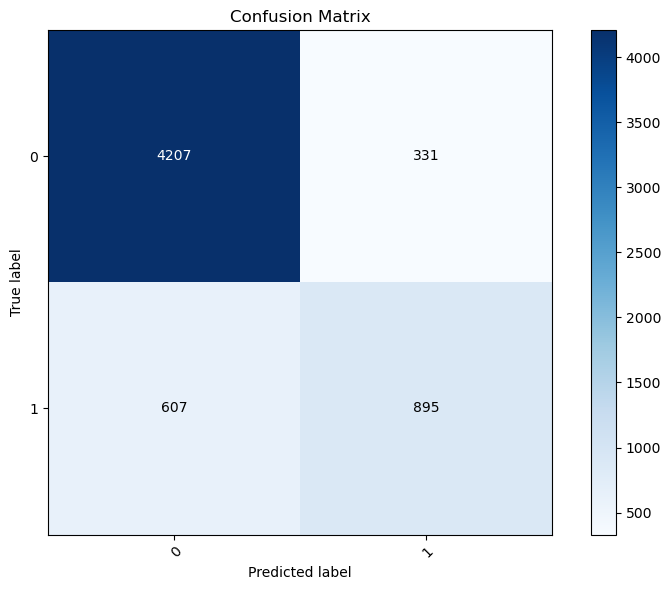

In [11]:
# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [12]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
# np.logspace(-4,4,2-) tells GridSearchCV to test 20 values for C eenly spaced on logarithmic scale from 10^-4 to 10^4
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
}

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', random_state=42, max_iter=200),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/kennedygracemaloney/miniconda3/envs/pyml-book/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kennedygracemaloney/miniconda3/envs/pyml-book/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             scoring='accuracy', verbose=1)


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1.623776739188721}
Best cross-validation accuracy: 0.8476

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8449

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4538
           1       0.73      0.60      0.66      1502

    accuracy                           0.84      6040
   macro avg       0.80      0.76      0.78      6040
weighted avg       0.84      0.84      0.84      6040


Confusion Matrix:
[[4207  331]
 [ 606  896]]


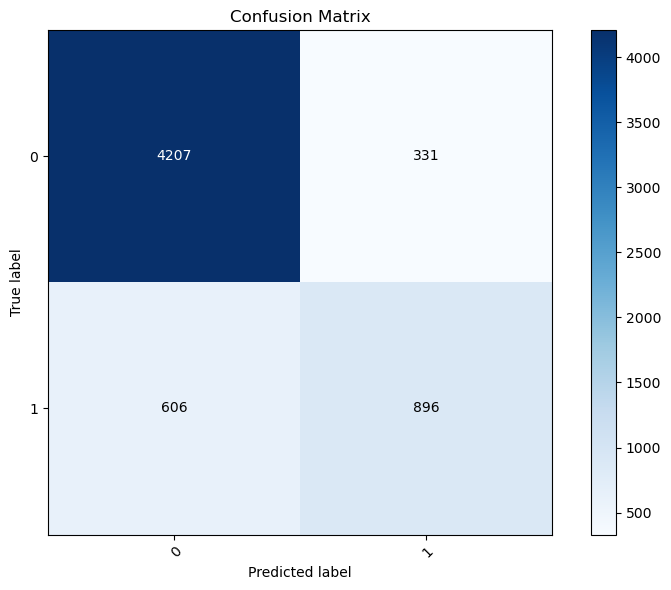

In [13]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [32]:
# Load validation data
val_df = pd.read_csv("/Users/kennedygracemaloney/Downloads/project_validation_inputs.csv")

# Preprocess validation data with same encoders/scaler
X_val, _ = preprocess_data(val_df, has_target=False, le=le, scaler=scaler)

# Align columns so they match training
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

# Now predictions will work
y_pred = model.predict(X_val)

# Save outputs
pd.DataFrame({"prediction": y_pred}).to_csv("validation_predictions.csv", index=False)


In [33]:
# Initialize full predictions with NaN
full_predictions = pd.Series(index=val_df.index, dtype=object)

# Fill predictions for rows that survived preprocessing
full_predictions[X_val.index] = y_pred

results = val_df.copy()
results["prediction"] = full_predictions

results.to_csv("validation_with_predictions.csv", index=False)
